In [1]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

In [2]:
chart_data = pd.DataFrame.from_csv('CHART_EVENTS_FIRST24_PROCESSED.csv')
lab_data = pd.DataFrame.from_csv('LAB_EVENTS_FIRST24_PROCESSED.csv')
chart_data.head()

,icustay_id,subject_id,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,BP_Dia_std,BP_Mean_max,BP_Mean_mean,...,pH2_med,pH2_min,pH2_skew,pH2_std,pH_max,pH_mean,pH_med,pH_min,pH_skew,pH_std
0,200001,55973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200003,27513,81.0,42.708333,60.5,0.0,-0.623249,31.452489,179.0,87.411765,...,7.38,7.36,1.220037,0.038987,7.46,7.398,7.38,7.36,1.220037,0.038987
2,200006,10950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200007,20707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200009,29904,84.0,62.645161,57.0,49.0,0.868910,10.931753,101.0,74.741935,...,7.39,7.29,0.360059,0.071063,7.50,7.380,7.39,7.29,0.360059,0.071063


In [3]:
donkey = [x for x in chart_data.columns if 'time' in x]
for donk in donkey:
    chart_data[donk] = pd.to_datetime(chart_data[donk])

for index, row in chart_data.iterrows():
    staylen = relativedelta(row['outtime'], row['intime']).hours
    chart_data.set_value(index, 'stay_duration', staylen)


In [4]:
chart_data2 = chart_data.set_index(['icustay_id'], inplace = False)
lab_data2 = lab_data.set_index(['icustay_id'], inplace = False)

In [5]:
display(lab_data2.head())
display(chart_data2.head())

,subject_id,Lactate_max_df,Lactate_mean_df,Lactate_med_df,Lactate_min_df,Lactate_skew_df,Lactate_std_df,O2sat_max_df,O2sat_mean_df,O2sat_med_df,...,gender,hospital_expire_flag,intime,outtime,pH_max_df,pH_mean_df,pH_med_df,pH_min_df,pH_skew_df,pH_std_df
icustay_id,,,,,,,,,,,,,,,,,,,,,
205291,24802,0.8,0.800000,0.8,0.8,NaN,NaN,99.0,92.875000,98.0,...,F,0,2159-02-01 10:29:42,2159-02-02 16:05:51,7.46,7.325833,7.325,7.26,1.114474,0.057597
267509,24804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,M,0,2160-12-16 00:14:00,2160-12-21 13:57:00,5.00,5.000000,5.000,5.00,NaN,0.000000
204824,24846,3.7,2.866667,2.7,2.2,0.93522,0.763763,NaN,NaN,NaN,...,M,0,2122-12-23 03:05:01,2122-12-23 18:34:40,6.50,6.500000,6.500,6.50,NaN,NaN
210799,24772,4.5,4.500000,4.5,4.5,NaN,NaN,95.0,74.142857,64.0,...,F,0,2182-09-05 09:54:52,2182-09-17 12:13:23,7.56,7.402000,7.380,7.31,0.741323,0.072329
206949,24825,2.5,2.500000,2.5,2.5,NaN,NaN,NaN,NaN,NaN,...,M,1,2167-01-27 15:21:31,2167-01-30 17:33:46,7.41,6.603333,7.400,5.00,-1.731950,1.388536


,subject_id,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,BP_Dia_std,BP_Mean_max,BP_Mean_mean,BP_Mean_med,...,pH2_min,pH2_skew,pH2_std,pH_max,pH_mean,pH_med,pH_min,pH_skew,pH_std,stay_duration
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,55973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
200003,27513,81.0,42.708333,60.5,0.0,-0.623249,31.452489,179.0,87.411765,80.0,...,7.36,1.220037,0.038987,7.46,7.398,7.38,7.36,1.220037,0.038987,21.0
200006,10950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
200007,20707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
200009,29904,84.0,62.645161,57.0,49.0,0.868910,10.931753,101.0,74.741935,69.0,...,7.29,0.360059,0.071063,7.50,7.380,7.39,7.29,0.360059,0.071063,3.0


In [6]:
lab_data2.drop(['hospital_expire_flag', 'subject_id', 'gender', 'intime', 'outtime'], 
               axis = 1, inplace = True)

all_data = chart_data2.merge(lab_data2, left_index = True, right_index = True, how='left', sort = True, 
                            suffixes = ('chart', 'lab'))
all_data.dtypes

subject_id           int64
BP_Dia_max         float64
BP_Dia_mean        float64
BP_Dia_med         float64
BP_Dia_min         float64
BP_Dia_skew        float64
BP_Dia_std         float64
BP_Mean_max        float64
BP_Mean_mean       float64
BP_Mean_med        float64
BP_Mean_min        float64
BP_Mean_skew       float64
BP_Mean_std        float64
BP_Sys_max         float64
BP_Sys_mean        float64
BP_Sys_med         float64
BP_Sys_min         float64
BP_Sys_skew        float64
BP_Sys_std         float64
Cap_refill          object
GCS_Eye             object
GCS_Motor           object
GCS_Verbal          object
GCS_total          float64
HR_max             float64
HR_mean            float64
HR_med             float64
HR_min             float64
HR_skew            float64
HR_std             float64
                    ...   
pH2_min            float64
pH2_skew           float64
pH2_std            float64
pH_max             float64
pH_mean            float64
pH_med             float64
p

In [7]:
all_data['icustay_id'] = all_data.index
all_data.set_index(np.arange(all_data.shape[0]), inplace = True)

In [8]:
cols = list(all_data.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
all_data = all_data[cols]


all_data.columns

Index([u'icustay_id', u'subject_id', u'BP_Dia_max', u'BP_Dia_mean',
       u'BP_Dia_med', u'BP_Dia_min', u'BP_Dia_skew', u'BP_Dia_std',
       u'BP_Mean_max', u'BP_Mean_mean', u'BP_Mean_med', u'BP_Mean_min',
       u'BP_Mean_skew', u'BP_Mean_std', u'BP_Sys_max', u'BP_Sys_mean',
       u'BP_Sys_med', u'BP_Sys_min', u'BP_Sys_skew', u'BP_Sys_std',
       u'Cap_refill', u'GCS_Eye', u'GCS_Motor', u'GCS_Verbal', u'GCS_total',
       u'HR_max', u'HR_mean', u'HR_med', u'HR_min', u'HR_skew', u'HR_std',
       u'Height', u'Lactate_max_df', u'Lactate_mean_df', u'Lactate_med_df',
       u'Lactate_min_df', u'Lactate_skew_df', u'Lactate_std_df',
       u'O2_Fraction_max', u'O2_Fraction_mean', u'O2_Fraction_med',
       u'O2_Fraction_min', u'O2_Fraction_skew', u'O2_Fraction_std',
       u'O2sat_max_df', u'O2sat_mean_df', u'O2sat_med_df', u'O2sat_min_df',
       u'O2sat_skew_df', u'O2sat_std_df', u'RR_max', u'RR_mean', u'RR_med',
       u'RR_min', u'RR_skew', u'RR_std', u'TempC_Calc_max', u'TempC_Calc

## Isolate continuous (float64) and categorical variables for feature selection process. 
Feature selection tools require features to be of the same type. Data will be separated, feature correlations will be calculated. 
### height, weight, gcs_total are not being included in these groupings and should be considered separately

In [9]:
monkey = list(all_data.columns[all_data.dtypes == 'float64'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
monkey.pop(monkey.index('Height'))
monkey.pop(monkey.index('Weight'))
cont_data = all_data[monkey]

monkey = list(all_data.columns[all_data.dtypes == 'object'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
cat_data = all_data[monkey]


In [10]:
cont_data.dtypes

icustay_id                int64
hospital_expire_flag      int64
BP_Dia_max              float64
BP_Dia_mean             float64
BP_Dia_med              float64
BP_Dia_min              float64
BP_Dia_skew             float64
BP_Dia_std              float64
BP_Mean_max             float64
BP_Mean_mean            float64
BP_Mean_med             float64
BP_Mean_min             float64
BP_Mean_skew            float64
BP_Mean_std             float64
BP_Sys_max              float64
BP_Sys_mean             float64
BP_Sys_med              float64
BP_Sys_min              float64
BP_Sys_skew             float64
BP_Sys_std              float64
GCS_total               float64
HR_max                  float64
HR_mean                 float64
HR_med                  float64
HR_min                  float64
HR_skew                 float64
HR_std                  float64
Lactate_max_df          float64
Lactate_mean_df         float64
Lactate_med_df          float64
                         ...   
TempC_Ca

## This filtering on feature selection could be done far earlier in the process. Could do it in smaller blocks where the variables are aligned with the subject ID
Variables are not present for all subject_id's or ICU stays. In order to select features, we need to drop_na. So we need to find blocks of features that are present for the same ICU stays etc. In retrospect this could be done earlier in the process before all the data is merged. 

## CREATING CONTINUOUS / FLOAT64 DATA BLOCKS FOR FEATURE SELECTION
### GCS_total, stay_duration are not included in these blocks and need to be considered separately 

In [11]:
cont_data.columns

Index([u'icustay_id', u'hospital_expire_flag', u'BP_Dia_max', u'BP_Dia_mean',
       u'BP_Dia_med', u'BP_Dia_min', u'BP_Dia_skew', u'BP_Dia_std',
       u'BP_Mean_max', u'BP_Mean_mean', u'BP_Mean_med', u'BP_Mean_min',
       u'BP_Mean_skew', u'BP_Mean_std', u'BP_Sys_max', u'BP_Sys_mean',
       u'BP_Sys_med', u'BP_Sys_min', u'BP_Sys_skew', u'BP_Sys_std',
       u'GCS_total', u'HR_max', u'HR_mean', u'HR_med', u'HR_min', u'HR_skew',
       u'HR_std', u'Lactate_max_df', u'Lactate_mean_df', u'Lactate_med_df',
       u'Lactate_min_df', u'Lactate_skew_df', u'Lactate_std_df',
       u'O2_Fraction_max', u'O2_Fraction_mean', u'O2_Fraction_med',
       u'O2_Fraction_min', u'O2_Fraction_skew', u'O2_Fraction_std',
       u'O2sat_max_df', u'O2sat_mean_df', u'O2sat_med_df', u'O2sat_min_df',
       u'O2sat_skew_df', u'O2sat_std_df', u'RR_max', u'RR_mean', u'RR_med',
       u'RR_min', u'RR_skew', u'RR_std', u'TempC_Calc_max', u'TempC_Calc_mean',
       u'TempC_Calc_med', u'TempC_Calc_min', u'TempC_Cal

In [12]:
[x for x in lab_data.columns if '_df' in x]

['Lactate_max_df',
 'Lactate_mean_df',
 'Lactate_med_df',
 'Lactate_min_df',
 'Lactate_skew_df',
 'Lactate_std_df',
 'O2sat_max_df',
 'O2sat_mean_df',
 'O2sat_med_df',
 'O2sat_min_df',
 'O2sat_skew_df',
 'O2sat_std_df',
 'pH_max_df',
 'pH_mean_df',
 'pH_med_df',
 'pH_min_df',
 'pH_skew_df',
 'pH_std_df']

In [13]:
cols = ['icustay_id', 'hospital_expire_flag', 'GCS_total']
cont_data_GCST = cont_data[cols].dropna()
cont_data_GCST.reset_index(drop = True, inplace = True)
print "GCS_total  = {}".format(cont_data_GCST.shape[0])

cols = ['icustay_id', 'hospital_expire_flag', 'stay_duration']
cont_data_Stay = cont_data[cols].dropna()
cont_data_Stay.reset_index(drop = True, inplace = True)
print "Stay_total  = {}".format(cont_data_Stay.shape[0])

cols = [x for x in cont_data.columns if 'Lactate_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_Lac = cont_data[cols].dropna()
cont_data_Lac.reset_index(drop = True, inplace = True)
print "Lactate  = {}".format(cont_data_Lac.shape[0])

cols = [x for x in cont_data.columns if 'O2sat_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_O2sat = cont_data[cols].dropna()
cont_data_O2sat.reset_index(drop = True, inplace = True)
print "O2sat  = {}".format(cont_data_O2sat.shape[0])

cols = [x for x in cont_data.columns if (('pH_' in x) | ('_df' in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_labpH = cont_data[cols].dropna()
cont_data_labpH.reset_index(drop = True, inplace = True)
print "labpH  = {}".format(cont_data_labpH.shape[0])


cols = [x for x in cont_data.columns if 'BP_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_BP = cont_data[cols].dropna()
cont_data_BP.reset_index(drop = True, inplace = True)
print "BP  = {}".format(cont_data_BP.shape[0])

cols = [x for x in cont_data.columns if 'HR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_HR = cont_data[cols].dropna()
cont_data_HR.reset_index(drop = True, inplace = True)
print "HR  = {}".format(cont_data_HR.shape[0])


cols = [x for x in cont_data.columns if 'O2_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_O2 = cont_data[cols].dropna()
cont_data_O2.reset_index(drop = True, inplace = True)
print "O2  = {}".format(cont_data_O2.shape[0])

cols = [x for x in cont_data.columns if 'RR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_RR = cont_data[cols].dropna()
cont_data_RR.reset_index(drop = True, inplace = True)
print "RR  = {}".format(cont_data_RR.shape[0])


cols = [x for x in cont_data.columns if 'TempC_Calc' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TCalc = cont_data[cols].dropna()
cont_data_TCalc.reset_index(drop = True, inplace = True)
print "TCalc  = {}".format(cont_data_TCalc.shape[0])

cols = [x for x in cont_data.columns if (('TempC_' in x) & ('TempC_C' not in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TC = cont_data[cols].dropna()
cont_data_TC.reset_index(drop = True, inplace = True)
print "TC  = {}".format(cont_data_TC.shape[0])

cols = [x for x in cont_data.columns if (('pH_' in x) | ('pH2_' in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_pH = cont_data[cols].dropna()
cont_data_pH.reset_index(drop = True, inplace = True)
print "pH  = {}".format(cont_data_pH.shape[0])

cont_dict = {'BP': cont_data_BP, 
             'HR': cont_data_HR, 
             'O2': cont_data_O2, 
             'RR': cont_data_RR, 
             'TCalc': cont_data_TCalc, 
             'TC': cont_data_TC,
             'pH': cont_data_pH,
             'GCST': cont_data_GCST, 
             'Stay': cont_data_Stay,
             'LAC' : cont_data_Lac, 
             'O2Sat': cont_data_O2sat, 
             'labpH' : cont_data_labpH
            }




GCS_total  = 28787
Stay_total  = 60131
Lactate  = 12144
O2sat  = 8359
labpH  = 1967
BP  = 15175
HR  = 57442
O2  = 10177
RR  = 52067
TCalc  = 24169
TC  = 4922
pH  = 11032


## FILTERING OUTLIERS FROM CONTINUOUS/FLOAT64 DATA BLOCKS

In [14]:
suffix = '_outliers'


# ITERATE THROUGH DATAFRAMES IN cont_dict 
# DOING ONE LOOP FOR DEVELOPMENT
for key in cont_dict.keys():
    
    
    names_dict = {}
    for feature in cont_dict[key].columns[2:]:
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(cont_dict[key][feature], 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(cont_dict[key][feature], 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        # BECAUSE DATA IS NOT NORMAL EXPLORING DIFFERENT RANGE FACTORS
        step = 5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = cont_dict[key][~((cont_dict[key][feature] >= Q1 - step) & 
                                                      (cont_dict[key][feature] <= Q3 + step))].index
    # OPTIONAL: Select the indices for data points you wish to remove

    
    all_outliers = []
    for feature in names_dict.keys():
        all_outliers.extend(names_dict[feature])
    print "the total outlier indices for {} = {}".format(key, len(all_outliers))
    indices, counts = np.unique(all_outliers, return_counts = True)
    outlier_dict = {'counts': counts,
                    'indices': indices
                   }
    outlier_df = pd.DataFrame(outlier_dict)

    outliers  = list(outlier_df[outlier_df.counts >= 1].indices.values)
    #print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
    # Remove the outliers, if any were specified



    cont_dict[key] = cont_dict[key].drop(cont_dict[key].index[outliers]).reset_index(drop = True)

the total outlier indices for HR = 207
the total outlier indices for TCalc = 176
the total outlier indices for O2Sat = 340
the total outlier indices for BP = 599
the total outlier indices for pH = 344
the total outlier indices for Stay = 0
the total outlier indices for O2 = 12
the total outlier indices for GCST = 0
the total outlier indices for RR = 366
the total outlier indices for LAC = 546
the total outlier indices for labpH = 214
the total outlier indices for TC = 44


## DISPLAY CONTINUOUS/FLOAT64 DATA BLOCK SUMMARY STATS WITH OUTLIERS REMOVED

In [15]:
display(cont_dict[key].describe())
#cont_dict[key].head()

,icustay_id,hospital_expire_flag,TempC_max,TempC_mean,TempC_med,TempC_min,TempC_skew,TempC_std
count,4896.000000,4896.000000,4896.000000,4896.000000,4896.000000,4896.000000,4896.000000,4896.000000
mean,250282.378881,0.084967,37.822141,37.004755,37.119335,35.907716,-0.348980,0.597583
std,28903.479908,0.278862,0.657289,0.590872,0.631301,0.907898,0.706478,0.312764
min,200009.000000,0.000000,34.000000,33.600000,33.099998,30.600000,-4.668762,0.000000
25%,225006.000000,0.000000,37.400002,36.670588,36.799999,35.400002,-0.787955,0.363114
50%,250874.000000,0.000000,37.799999,37.005481,37.200001,35.900002,-0.376037,0.568530
75%,275311.250000,0.000000,38.200001,37.349235,37.500000,36.500000,0.067252,0.788502
max,299988.000000,1.000000,41.700001,39.795000,39.799999,39.099998,3.280752,2.437065


## PLOT DENSITY OF CONTINUOUS/FLOAT64 VARIABLES WITH OUTLIERS REMOVED

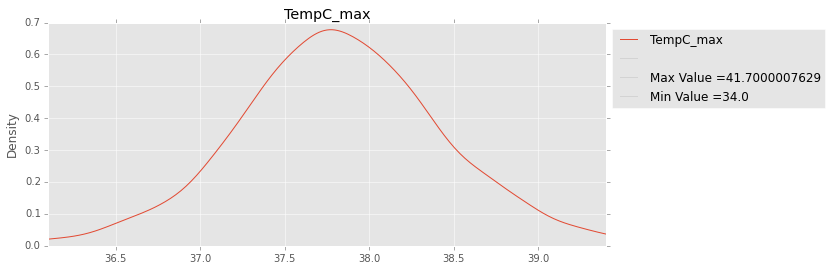

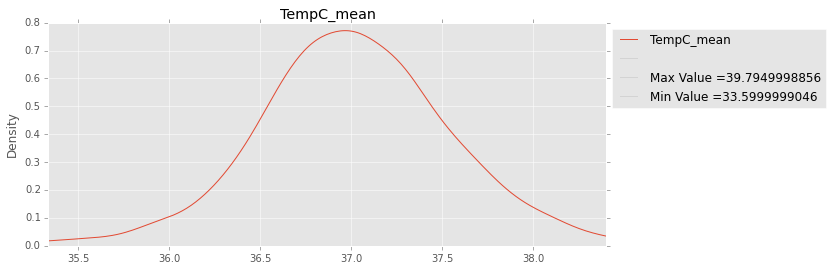

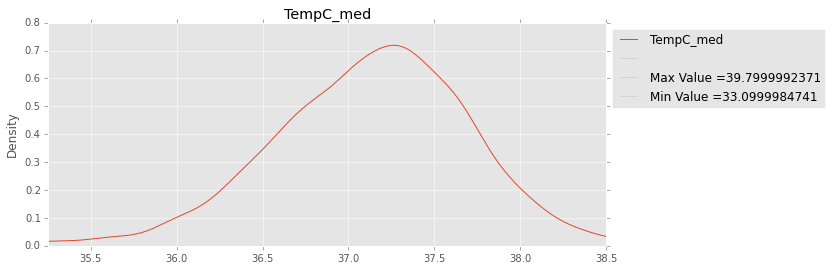

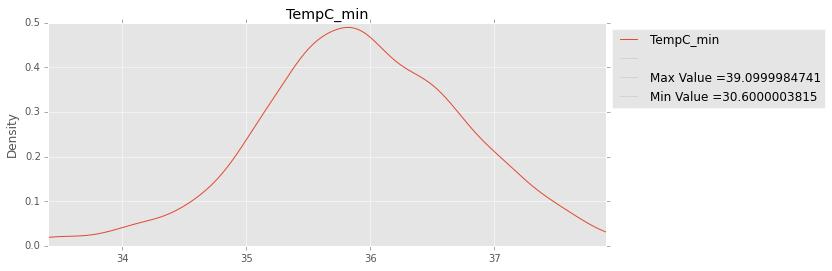

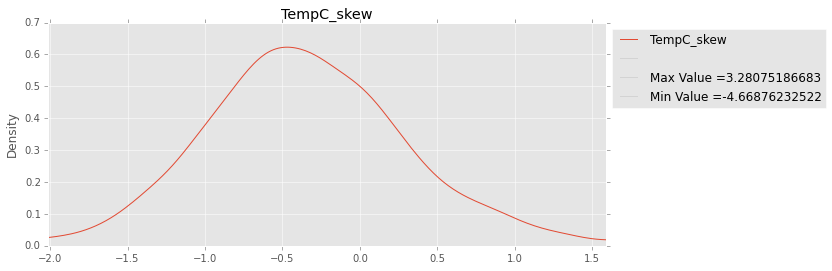

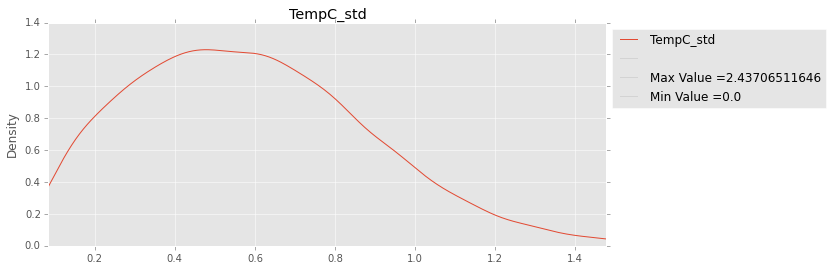

In [16]:
for col in cont_dict[key].columns[2:]:
    plt.subplots(figsize=(10,4))
    cont_dict[key][col].plot.kde()
    xmin = np.percentile(cont_dict[key][col], 1)
    xmax = np.percentile(cont_dict[key][col], 99)
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='Max Value ={}'.format(cont_dict[key][col].max()),
             color='lightgray')
    plt.plot([], label='Min Value ={}'.format(cont_dict[key][col].min()),
             color='lightgray')

    plt.xlim(xmin, xmax)
    plt.title(col)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)

#cont_dict['BP'].shape

### USING NUMBERS OF NAN TO GET CLUE ABOUT WHICH VARIABLES ARE BLOCKED TOGETHER

## FEATURE SELECTION FOR CONTINUOUS/FLOAT64 DATA

In [17]:
cont_dict.keys()

['HR',
 'TCalc',
 'O2Sat',
 'BP',
 'pH',
 'Stay',
 'O2',
 'GCST',
 'RR',
 'LAC',
 'labpH',
 'TC']

In [18]:
cont_feature_scores = pd.DataFrame()

for key in cont_dict.keys():

    X_cont = cont_dict[key].drop(['hospital_expire_flag', 'icustay_id'], axis = 1)
    y_cont = cont_dict[key]['hospital_expire_flag']
    below_zeros = list(X_cont.columns[X_cont.min() < 0])
    # SelectKBest can't deal with negative numbers so we shift any variables with negative values
    # up so that the most negative values = 0
    for col in below_zeros:
        col_min = X_cont[col].min()
        X_cont[col] = X_cont[col].apply(lambda x: x-col_min)
    
    selector = SelectKBest(k='all')
    selector.fit(X_cont, y_cont)
    d = {'pvalues': pd.Series(selector.pvalues_, index = X_cont.columns),
         'scores' : pd.Series(selector.scores_, index = X_cont.columns)
        }
    cont_feature_scores = cont_feature_scores.append(pd.DataFrame(d))

cont_feature_scores.sort_values(['pvalues'], axis = 0, ascending = True, inplace = True)

tops = cont_feature_scores.head(20).transpose().columns
bottoms = cont_feature_scores.tail(20).transpose().columns
display(tops[:5])
display(bottoms[:3])
display(cont_dict.keys())

Index([u'RR_med', u'GCS_total', u'RR_mean', u'HR_std', u'Lactate_min_df'], dtype='object')

Index([u'O2sat_med_df', u'TempC_Calc_max', u'O2_Fraction_max'], dtype='object')

['HR',
 'TCalc',
 'O2Sat',
 'BP',
 'pH',
 'Stay',
 'O2',
 'GCST',
 'RR',
 'LAC',
 'labpH',
 'TC']

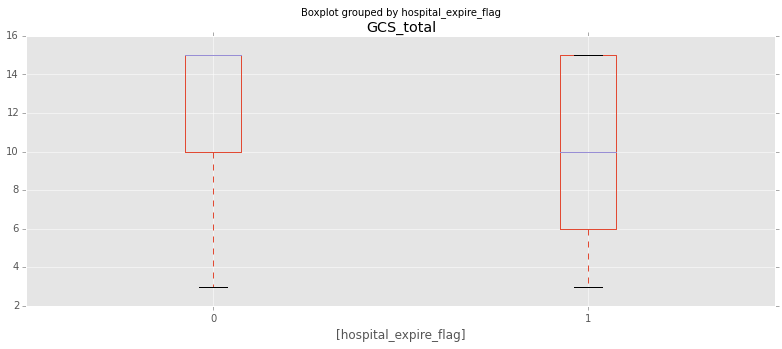

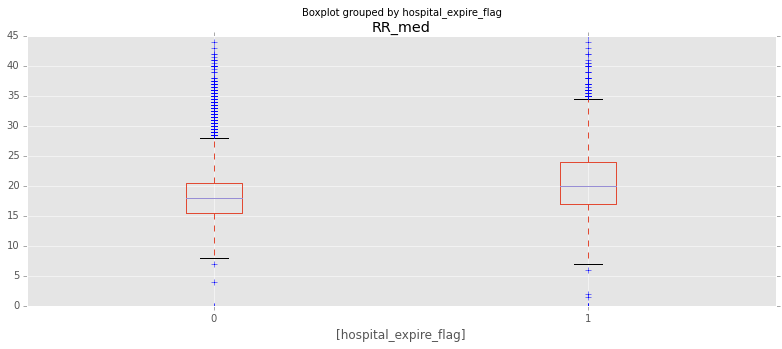

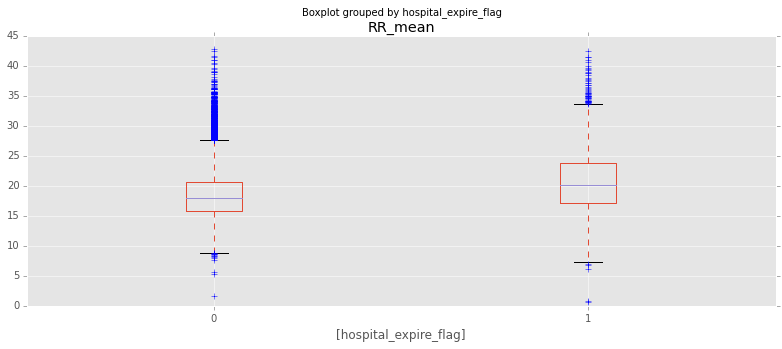

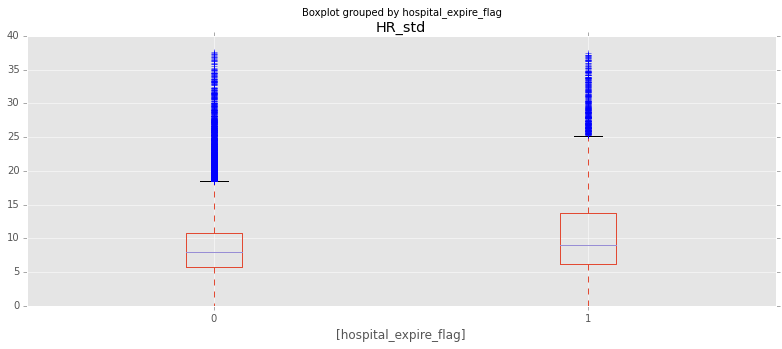

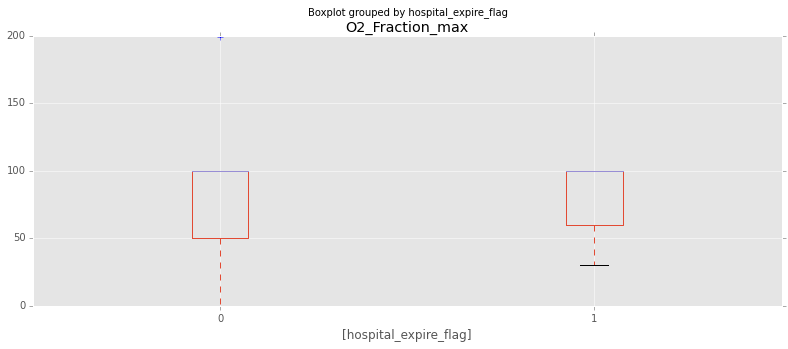

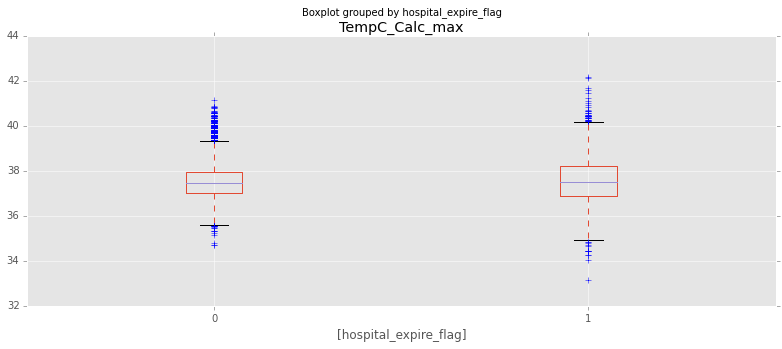

In [19]:
#cont_dict['RR'].plot.scatter(x='hospital_expire_flag', y='RR_med')
#for col in cont_dict['GCST'][''.columns[2:]:
cont_dict['GCST'][['hospital_expire_flag','GCS_total']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['RR'][['hospital_expire_flag','RR_med']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['RR'][['hospital_expire_flag','RR_mean']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['HR'][['hospital_expire_flag','HR_std']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['O2'][['hospital_expire_flag','O2_Fraction_max']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['TCalc'][['hospital_expire_flag','TempC_Calc_max']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))



#data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))

In [20]:
cont_feature_scores.to_csv('Continuous_Feature_Scores.csv')

In [21]:
for col in cat_data.columns:
    print "{} has  {} NaN values".format(col, cat_data[col].isnull().sum())

icustay_id has  0 NaN values
hospital_expire_flag has  0 NaN values
Cap_refill has  54204 NaN values
GCS_Eye has  36828 NaN values
GCS_Motor has  36841 NaN values
GCS_Verbal has  36838 NaN values
charttimelab has  14075 NaN values
flag has  47683 NaN values
gender has  0 NaN values


## CREATING BLOCK OF CATEGORICAL DATA FOR FEATURE SELECTION
### Cap refill and gender are not included in this block and should be evaluated separately

In [22]:
cols = [x for x in cat_data.columns if ('GCS_' in x)]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cat_data_GCS = cat_data[cols].dropna()
print "GCS  = {}".format(cat_data_GCS.shape[0])

cols = ['icustay_id', 'hospital_expire_flag','gender']
cat_data_gender = cat_data[cols].dropna()
#cols.insert(0, cols.pop(cols.index('icustay_id')))
#cols.insert(1, cols.pop(cols.index('subject_id')))
print "gender = {}".format(cat_data_gender.shape[0])




GCS  = 23280
gender = 60131


In [23]:
cat_data_GCS.columns

Index([u'icustay_id', u'hospital_expire_flag', u'GCS_Eye', u'GCS_Motor',
       u'GCS_Verbal'],
      dtype='object')

## Create OneHotEncoded data from categorical data in GCS and Gender dataframes

In [25]:
cols = cat_data_GCS.columns[2:]
cat_data_GCS2 = pd.get_dummies(cat_data_GCS[cols], prefix= cols)

cols = cat_data_gender.columns[2:]
cat_data_gender2 = pd.get_dummies(cat_data_gender[cols], prefix= cols)



In [26]:
cat_data_GCS2.head()

,GCS_Eye_None,GCS_Eye_Spontaneously,GCS_Eye_To Pain,GCS_Eye_To Speech,GCS_Motor_Abnormal Flexion,GCS_Motor_Abnormal extension,GCS_Motor_Flex-withdraws,GCS_Motor_Localizes Pain,GCS_Motor_No response,GCS_Motor_Obeys Commands,GCS_Verbal_Confused,GCS_Verbal_Inappropriate Words,GCS_Verbal_Incomprehensible sounds,GCS_Verbal_No Response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
cat_dict['GCS'][1].head()

,GCS_Eye_None,GCS_Eye_Spontaneously,GCS_Eye_To Pain,GCS_Eye_To Speech,GCS_Motor_Abnormal Flexion,GCS_Motor_Abnormal extension,GCS_Motor_Flex-withdraws,GCS_Motor_Localizes Pain,GCS_Motor_No response,GCS_Motor_Obeys Commands,GCS_Verbal_Confused,GCS_Verbal_Inappropriate Words,GCS_Verbal_Incomprehensible sounds,GCS_Verbal_No Response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## PERFORMING FEATURE SELECTION USING ONEHOTENCODED VARIABLES 
### SAVING P-VALUES AND SCORES FOR ALL CATEGORICAL VARIABLES IN A DATAFRAME cat_feature_Scores

In [27]:
# CREATE DICT WITH CATEGORICAL AND ASSOCIATED ONEHOTENCODED DATA REFERENCED BY EACH KEY 
cat_dict = {'GCS': [cat_data_GCS, cat_data_GCS2], 
            'Gend': [cat_data_gender, cat_data_gender2] 
            }

cat_feature_scores = pd.DataFrame()

for key in cat_dict.keys():

    X_cat = cat_dict[key][1]
    y_cat = cat_dict[key][0]['hospital_expire_flag']
   
    # SelectKBest can't deal with negative numbers so we shift any variables with negative values
    # up so that the most negative values = 0
   
    selector = SelectKBest(score_func = chi2, k='all')
    selector.fit(X_cat, y_cat)
    d = {'pvalues': pd.Series(selector.pvalues_, index = X_cat.columns),
         'scores' : pd.Series(selector.scores_, index = X_cat.columns)
        }
    cat_feature_scores = cat_feature_scores.append(pd.DataFrame(d))

cat_feature_scores.sort_values(['pvalues'], axis = 0, ascending = True, inplace = True)

tops = cat_feature_scores.head().transpose().columns
bottoms = cat_feature_scores.tail().transpose().columns
display(tops)
display(bottoms)
display(cat_dict.keys())

Index([u'GCS_Eye_None', u'GCS_Motor_No response',
       u'GCS_Verbal_No Response-ETT', u'GCS_Verbal_Oriented',
       u'GCS_Motor_Flex-withdraws'],
      dtype='object')

Index([u'GCS_Verbal_Confused', u'gender_F', u'GCS_Verbal_Inappropriate Words',
       u'GCS_Eye_To Speech', u'gender_M'],
      dtype='object')

['GCS', 'Gend']

In [56]:
cat_feature_scores.index[:3]

Index([u'GCS_Eye_None', u'GCS_Motor_No response',
       u'GCS_Verbal_No Response-ETT'],
      dtype='object')

In [29]:
cat_feature_scores.to_csv('Categorical_Feature_Scores.csv')

In [33]:
display(cat_feature_scores.index[:3])
display(cat_feature_scores.index[-3:])


Index([u'GCS_Eye_None', u'GCS_Motor_No response',
       u'GCS_Verbal_No Response-ETT'],
      dtype='object')

Index([u'GCS_Verbal_Inappropriate Words', u'GCS_Eye_To Speech', u'gender_M'], dtype='object')

In [46]:
cat_dict['GCS'][0].head()

,icustay_id,hospital_expire_flag,GCS_Eye,GCS_Motor,GCS_Verbal
0,200001,0,Spontaneously,Obeys Commands,Oriented
5,200010,0,Spontaneously,Obeys Commands,Oriented
6,200011,0,Spontaneously,Obeys Commands,Oriented
9,200016,0,Spontaneously,Obeys Commands,Oriented
14,200021,0,Spontaneously,Obeys Commands,No Response-ETT


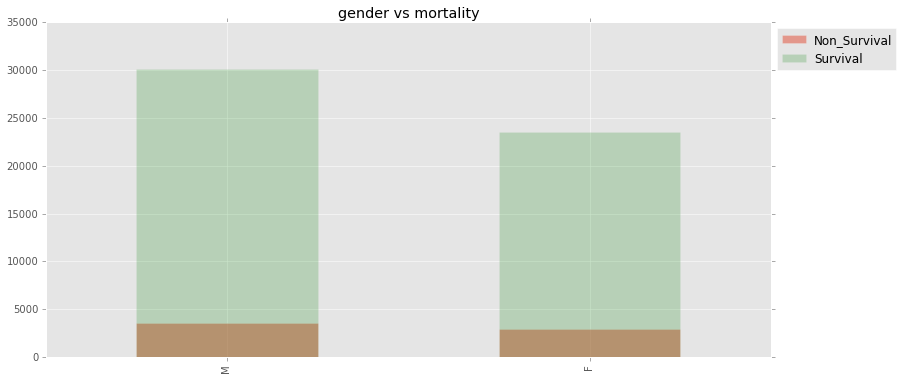

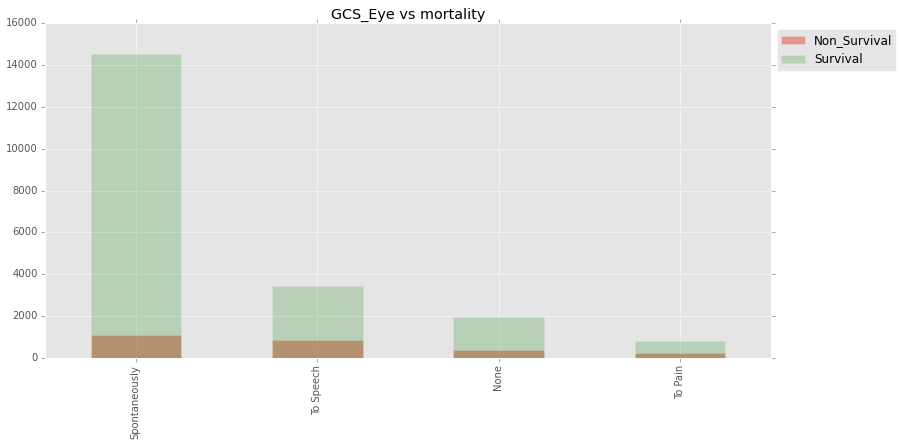

In [49]:

plt.subplots(figsize=(13,6))

cat_dict['Gend'][0]['gender'][cat_dict['Gend'][0].hospital_expire_flag ==1].value_counts().plot.bar(
        alpha = 0.5, label = 'Non_Survival')
cat_dict['Gend'][0]['gender'][cat_dict['Gend'][0].hospital_expire_flag ==0].value_counts().plot.bar(
        alpha = 0.2 , label = 'Survival', color = 'green')

plt.title('gender vs mortality')
    #plt.xlabel(l + ' ' + u)
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)


plt.subplots(figsize=(13,6))
cat_dict['GCS'][0]['GCS_Eye'][cat_dict['GCS'][0].hospital_expire_flag ==1].value_counts().plot.bar(
        alpha = 0.5, label = 'Non_Survival')
cat_dict['GCS'][0]['GCS_Eye'][cat_dict['GCS'][0].hospital_expire_flag ==0].value_counts().plot.bar(
        alpha = 0.2 , label = 'Survival', color = 'green')

plt.title('GCS_Eye vs mortality')
    #plt.xlabel(l + ' ' + u)
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)

In [50]:
display(cat_feature_scores.index[:3])
display(cat_feature_scores.index[-3:])

Index([u'GCS_Eye_None', u'GCS_Motor_No response',
       u'GCS_Verbal_No Response-ETT'],
      dtype='object')

Index([u'GCS_Verbal_Inappropriate Words', u'GCS_Eye_To Speech', u'gender_M'], dtype='object')

In [67]:
cat_dict['GCS'][0].head()

,icustay_id,hospital_expire_flag,GCS_Eye,GCS_Motor,GCS_Verbal
0,200001,0,Spontaneously,Obeys Commands,Oriented
5,200010,0,Spontaneously,Obeys Commands,Oriented
6,200011,0,Spontaneously,Obeys Commands,Oriented
9,200016,0,Spontaneously,Obeys Commands,Oriented
14,200021,0,Spontaneously,Obeys Commands,No Response-ETT


['GCS_Eye', 'GCS_Motor', 'GCS_Verbal', 'GCS_Verbal', 'GCS_Eye', 'gender']

## PLOTTING THE TOP 3 AND BOTTOM 3 CATEGORICAL FEATURES BY SELECTKBEST CHI2 SCORES 
### bit messy, need to clean up!


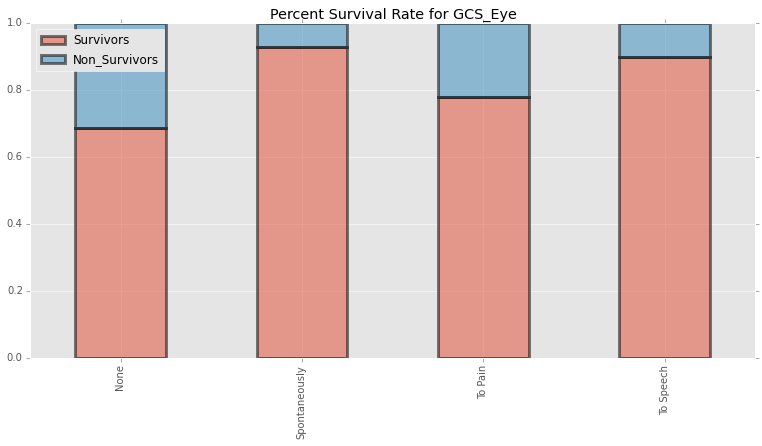

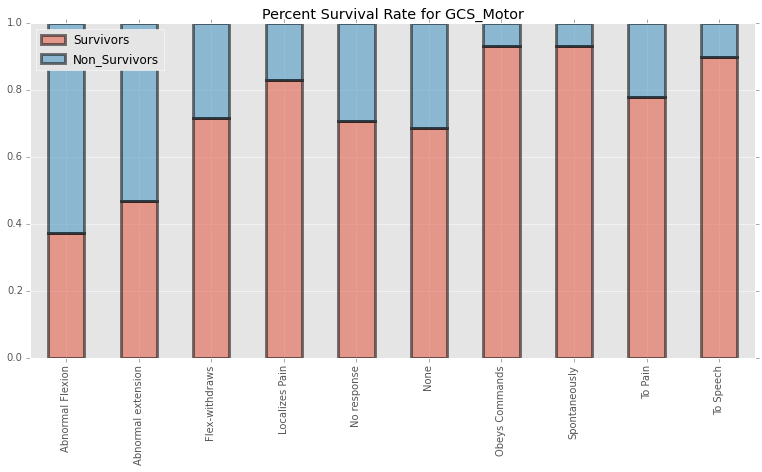

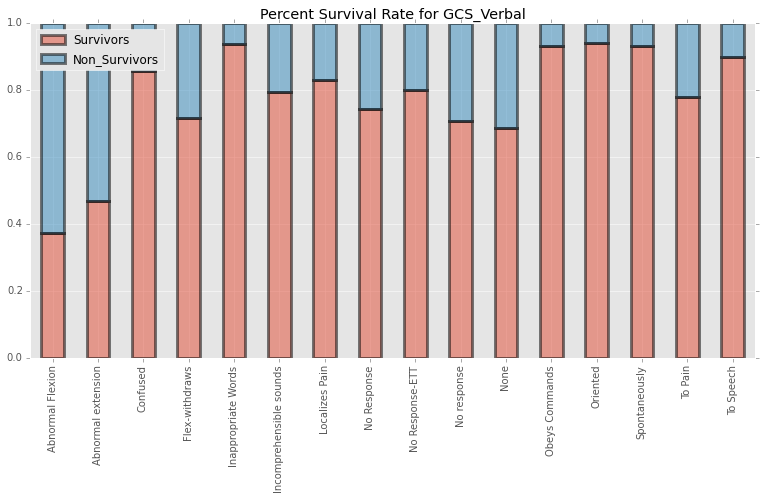

In [88]:
#
# THE ONE-HOT FRAMES DON'T HAVE HOSPITAL EXPIRED FLAG SO WE'RE PLOTTING THE RAW CATEGORICAL 
# FEATURES BASED ON THE SCORES OF THE ONEHOTENCODED FEATURES
# ALTERNATIVELY WE COULD MERGE ICUSTAY AND HOSPITAL EXPIRE FLAG INFO INTO ONE-HOT DATA. 

cat_vars = []
for col in cat_feature_scores.index[:3]:
    for col2  in cat_dict['GCS'][0].columns:
        if col2 in col:
            cat_vars.append(col2)




datadict = dict()
df = 'GCS'

for col in cat_vars: #feature_scores.index[:3]:
    
    
    
    cats = list(cat_dict[df][0][col].unique())
    for cat in cats:
        dead = cat_dict[df][0][col][(cat_dict[df][0][col] == cat) & (cat_dict[df][0].hospital_expire_flag == 1)].dropna().count()
        live = cat_dict[df][0][col][(cat_dict[df][0][col] == cat) & (cat_dict[df][0].hospital_expire_flag == 0)].dropna().count()
        total = float(live) + dead
        datadict[cat] = (live/total, dead/total)


    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + col)
    plt.show()














In [98]:
display(cont_dict.keys())
display(cont_feature_scores[:10])

['HR',
 'TCalc',
 'O2Sat',
 'BP',
 'pH',
 'Stay',
 'O2',
 'GCST',
 'RR',
 'LAC',
 'labpH',
 'TC']

,pvalues,scores
RR_med,0.000000e+00,1556.949181
GCS_total,0.000000e+00,1989.752238
RR_mean,3.952525e-322,1493.493979
HR_std,1.019289e-259,1197.533528
Lactate_min_df,7.826841e-259,1241.926427
Lactate_mean_df,8.571089e-209,990.049562
RR_max,2.286531e-205,943.607159
Lactate_med_df,5.875042e-182,856.992888
RR_std,5.808785e-164,750.044394
Lactate_max_df,4.725190e-157,734.761593


### cat_feature_scores contains scores from SelectKBest analysis using chi2
### cont_feature_scores contains scores from SelectKBest analysis using default
### cat_data contains all categorical data while cont_data contains all continuous/float64 data
### cont_features can be taken straight from cont_data but cat features have been transformed 


In [92]:
cat_feature_scores[:10]

,pvalues,scores
GCS_Eye_None,5.232463e-253,1154.293737
GCS_Motor_No response,8.864588e-134,605.867145
GCS_Verbal_No Response-ETT,8.252634e-107,481.898700
GCS_Verbal_Oriented,2.480360e-87,392.404059
GCS_Motor_Flex-withdraws,2.063374e-75,337.659578
GCS_Motor_Abnormal Flexion,4.555559e-73,326.897426
GCS_Motor_Obeys Commands,9.110050e-69,307.152600
GCS_Eye_Spontaneously,1.455077e-60,269.504572
GCS_Motor_Abnormal extension,4.793173e-43,189.183199
GCS_Verbal_No Response,7.098710e-36,156.350027


In [95]:
cont_feature_scores[cont_feature_scores.scores > 500]

,pvalues,scores
RR_med,0.000000e+00,1556.949181
GCS_total,0.000000e+00,1989.752238
RR_mean,3.952525e-322,1493.493979
HR_std,1.019289e-259,1197.533528
Lactate_min_df,7.826841e-259,1241.926427
Lactate_mean_df,8.571089e-209,990.049562
RR_max,2.286531e-205,943.607159
Lactate_med_df,5.875042e-182,856.992888
RR_std,5.808785e-164,750.044394
Lactate_max_df,4.725190e-157,734.761593


In [99]:
cat_data.columns

Index([u'icustay_id', u'hospital_expire_flag', u'Cap_refill', u'GCS_Eye',
       u'GCS_Motor', u'GCS_Verbal', u'charttimelab', u'flag', u'gender'],
      dtype='object')

In [105]:
#dropping columns that weren't used in feature identification
cols = list(cat_data.columns[2:])
cols.pop(cols.index('Cap_refill'))
cols.pop(cols.index('charttimelab'))
cols.pop(cols.index('flag'))

In [109]:
cols

['GCS_Eye', 'GCS_Motor', 'GCS_Verbal', 'gender']

In [115]:
cat_dummy_data = pd.get_dummies(cat_data[cols], prefix= cols)
cat_dummy_data['icustay_id'] = cat_data['icustay_id']
cat_dummy_data['hospital_expire_flag'] = cat_data['hospital_expire_flag']

cols = list(cat_dummy_data.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('hospital_expire_flag')))
cat_dummy_data = cat_dummy_data[cols]
cat_dummy_data.head()

,icustay_id,hospital_expire_flag,GCS_Eye_None,GCS_Eye_Spontaneously,GCS_Eye_To Pain,GCS_Eye_To Speech,GCS_Motor_Abnormal Flexion,GCS_Motor_Abnormal extension,GCS_Motor_Flex-withdraws,GCS_Motor_Localizes Pain,GCS_Motor_No response,GCS_Motor_Obeys Commands,GCS_Verbal_Confused,GCS_Verbal_Inappropriate Words,GCS_Verbal_Incomprehensible sounds,GCS_Verbal_No Response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented,gender_F,gender_M
0,200001,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,200003,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,200006,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,200007,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,200009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
cat_select_features = list(cat_feature_scores[:10].index)
cat_select_features.insert(0, 'icustay_id')
#could leave this out to avoid duplicates when merging w/ cont data later
cat_select_features.insert(1,'hospital_expire_flag') 

cat_select_data = cat_dummy_data[cat_select_features]
display(cat_dummy_data.shape)
display(cat_select_data.shape)
cat_select_data.head()


In [122]:
cont_data.head()

,icustay_id,hospital_expire_flag,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,BP_Dia_std,BP_Mean_max,BP_Mean_mean,...,pH_mean_df,pH_med,pH_med_df,pH_min,pH_min_df,pH_skew,pH_skew_df,pH_std,pH_std_df,stay_duration
0,200001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.908000,NaN,7.40,NaN,5.00,NaN,-2.231087,NaN,1.067085,1.0
1,200003,0,81.0,42.708333,60.5,0.0,-0.623249,31.452489,179.0,87.411765,...,6.998333,7.38,7.38,7.36,5.00,1.220037,-2.442453,0.038987,0.979600,21.0
2,200006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.000000,NaN,6.00,NaN,6.00,NaN,NaN,NaN,NaN,7.0
3,200007,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,200009,0,84.0,62.645161,57.0,49.0,0.868910,10.931753,101.0,74.741935,...,7.393000,7.39,7.39,7.29,7.29,0.360059,0.231694,0.071063,0.078606,3.0


In [123]:
cont_select_features = list(cont_feature_scores[cont_feature_scores.scores > 500].index)
cont_select_features.insert(0, 'icustay_id')
cont_select_features.insert(1,'hospital_expire_flag')
cont_select_data = cont_data[cont_select_features]
display(cont_data.shape)
display(cont_select_data.shape)
cont_select_data.head()

(60131, 82)

(60131, 19)

,icustay_id,hospital_expire_flag,RR_med,GCS_total,RR_mean,HR_std,Lactate_min_df,Lactate_mean_df,RR_max,Lactate_med_df,RR_std,Lactate_max_df,pH_med_df,pH2_min,pH_min,BP_Sys_min,pH_mean,pH2_mean,pH_mean_df
0,200001,0,20.0,NaN,21.230769,10.942648,1.4,1.400000,32.0,1.4,4.777511,1.4,7.40,NaN,NaN,NaN,NaN,NaN,6.908000
1,200003,0,33.0,15.0,29.288889,16.161433,2.6,3.933333,39.0,4.1,7.451730,5.1,7.38,7.36,7.36,0.0,7.398,7.398,6.998333
2,200006,0,20.0,15.0,19.047619,5.036017,3.1,3.100000,26.0,3.1,2.854403,3.1,6.00,NaN,NaN,NaN,NaN,NaN,6.000000
3,200007,0,22.0,15.0,21.520000,6.016286,NaN,NaN,29.0,NaN,3.618471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200009,0,16.0,10.0,16.161290,5.542019,0.7,2.000000,22.0,2.6,2.310797,2.7,7.39,7.29,7.29,86.0,7.380,7.380,7.393000


In [124]:
cont_feature_scores[cont_feature_scores.scores > 500]

,pvalues,scores
RR_med,0.000000e+00,1556.949181
GCS_total,0.000000e+00,1989.752238
RR_mean,3.952525e-322,1493.493979
HR_std,1.019289e-259,1197.533528
Lactate_min_df,7.826841e-259,1241.926427
Lactate_mean_df,8.571089e-209,990.049562
RR_max,2.286531e-205,943.607159
Lactate_med_df,5.875042e-182,856.992888
RR_std,5.808785e-164,750.044394
Lactate_max_df,4.725190e-157,734.761593


In [134]:
cont_select_data2 = cont_select_data.set_index(['icustay_id'], inplace = False)
cat_select_data2  = cat_select_data.set_index(['icustay_id'], inplace = False)
cat_select_data2.drop(['hospital_expire_flag'], axis = 1, inplace = True)

# scaling the continuous data
cont_select_data_scaled = cont_select_data2.dropna().copy()
for feature_name in cont_select_data_scaled.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
     cont_select_data_scaled[feature_name] = preprocessing.scale(cont_select_data_scaled[feature_name], 
                                                                 with_mean = True, with_std = True)
    

In [194]:
all_select_data = cont_select_data_scaled.merge(cat_select_data2, left_index = True, right_index = True, 
                                         how='left', sort = True, suffixes = ('cont', 'cat'))
all_select_data.dropna(inplace = True)
all_select_data.shape

(8815, 28)

In [195]:
monkey = all_select_data.groupby('hospital_expire_flag')['RR_med'].count()

float(monkey[1])/monkey[0]

0.24593639575971732

In [197]:
all_select_data.head()

,hospital_expire_flag,RR_med,GCS_total,RR_mean,HR_std,Lactate_min_df,Lactate_mean_df,RR_max,Lactate_med_df,RR_std,...,GCS_Eye_None,GCS_Motor_No response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented,GCS_Motor_Flex-withdraws,GCS_Motor_Abnormal Flexion,GCS_Motor_Obeys Commands,GCS_Eye_Spontaneously,GCS_Motor_Abnormal extension,GCS_Verbal_No Response
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,0,3.115674,1.209949,2.439469,1.192223,0.453056,0.600321,1.235944,0.690936,1.564598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200009,0,-0.525008,0.040977,-0.594885,-0.785291,-0.767920,-0.313229,-0.755031,-0.004077,-0.908298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200014,0,-1.488719,-0.660406,-0.892202,0.077428,-0.639396,-0.833008,0.533247,-0.791759,1.497464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200029,1,1.188254,-1.595584,0.600597,-0.694846,6.686462,4.553789,-0.286566,4.490341,1.072692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200030,0,0.331623,1.209949,0.350192,0.040041,-0.318087,0.410099,-0.052334,0.088591,-0.154852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVM CLASSIFICATION USING ALL SELECT DATA

In [213]:
X_train, X_test, y_train, y_test = train_test_split(all_select_data[all_select_data.columns[1:]], 
                                                    all_select_data['hospital_expire_flag'], 
                                                    test_size = 0.20, random_state = 42)

clf_SVC = svm.SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=4, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, all_select_data[all_select_data.columns[1:]], 
                         all_select_data['hospital_expire_flag'], cv=5)
display(scores)  

y_predsSVM = clf_SVC.predict(X_test)
metrics.confusion_matrix(y_test, y_predsSVM)



array([ 0.82870108,  0.83494044,  0.83153715,  0.82529779,  0.82473057])

## PCA AND CLASSIFICATION ON ALL SELECT DATA

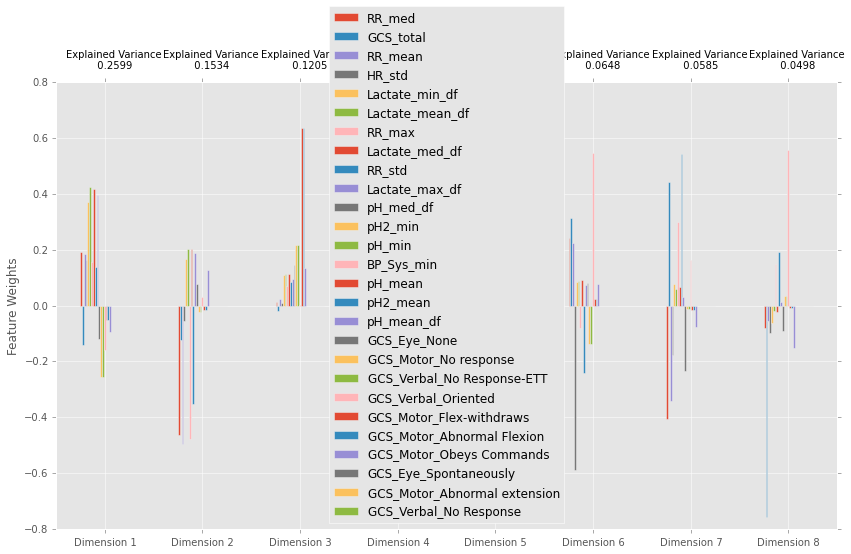

In [198]:
#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 8).fit(all_select_data[all_select_data.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(all_select_data[all_select_data.columns[1:]], pca)

In [216]:
all_reduced_data = pca.transform(all_select_data[all_select_data.columns[1:]])

# Create a DataFrame for the reduced data
all_reduced_data = pd.DataFrame(all_reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4',
                                                    'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
all_reduced_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8
0,2.650335,-3.778754,0.675214,-0.966727,-0.895917,-0.868641,-0.829470,-2.252595
1,-1.217284,1.131937,-0.195076,0.152566,0.467820,0.573054,-0.329130,-0.157398
2,-1.773746,-0.073453,0.358380,-0.756406,1.070503,-1.674470,1.171880,0.854775
3,8.670424,2.554084,1.327978,-1.890210,-1.479608,1.259739,0.499169,0.254060
4,0.236464,-0.318704,0.167051,-0.159477,-1.330314,0.660601,0.333574,-0.522998


In [217]:
# GAUSSIAN NAIVE BAYES CLASSIFIER WITH PCA COMPONENTS DERIVED FROM ALL DATA


X_train, X_test, y_train, y_test = train_test_split(all_reduced_data, 
                                                    all_select_data['hospital_expire_flag'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



0.820037807183


array([[1963,  169],
       [ 307,  206]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_reduced_data, 
                                                    all_select_data['hospital_expire_flag'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='poly', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, all_reduced_data, 
                         all_select_data['hospital_expire_flag'], cv=5)
display(scores)  

y_predsSVM = clf_SVC.predict(X_test)
metrics.confusion_matrix(y_test, y_predsSVM)



## PCA AND CLASSIFICATION USING SELECT CATEGORICAL DATA

In [181]:
cat_select_data3 = cat_select_data.set_index(['icustay_id'], inplace = False)

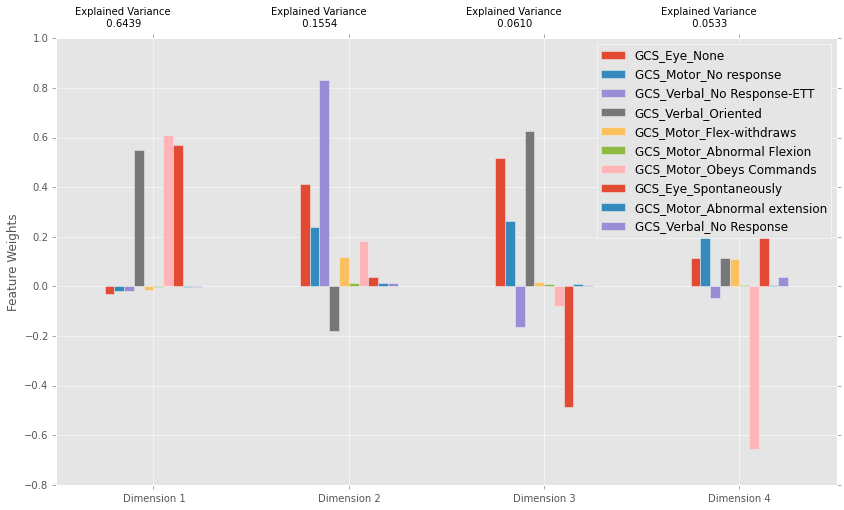

In [183]:
#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components =4).fit(cat_select_data3[cat_select_data3.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(cat_select_data3[cat_select_data3.columns[1:]], pca)

In [186]:
reduced_cat_data = pca.transform(cat_select_data3[cat_select_data3.columns[1:]])

# Create a DataFrame for the reduced data
reduced_cat_data = pd.DataFrame(reduced_cat_data, columns = ['Dimension 1', 'Dimension 2', 
                                                             'Dimension 3', 'Dimension 4'])
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_cat_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,1.271883,-0.094091,0.048068,0.067321
1,-0.456972,-0.135818,-0.012901,-0.001139
2,-0.456972,-0.135818,-0.012901,-0.001139
3,-0.456972,-0.135818,-0.012901,-0.001139
4,-0.456972,-0.135818,-0.012901,-0.001139


In [190]:
# Training using 80% of data and testing using 20%. 



X_train, X_test, y_train, y_test = train_test_split(reduced_cat_data, 
                                                    cat_select_data3['hospital_expire_flag'], 
                                                    test_size = .40, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



0.833908452168


array([[19621,  1832],
       [ 2163,   437]])

In [193]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, data2[data2.columns[1:]], data2['mort_icu'], cv=5)
display(scores)  

0.12088506132796481

In [192]:
monkey

,GCS_Eye_None,GCS_Motor_No response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented,GCS_Motor_Flex-withdraws,GCS_Motor_Abnormal Flexion,GCS_Motor_Obeys Commands,GCS_Eye_Spontaneously,GCS_Motor_Abnormal extension,GCS_Verbal_No Response
hospital_expire_flag,,,,,,,,,,
0,53646,53646,53646,53646,53646,53646,53646,53646,53646,53646
1,6485,6485,6485,6485,6485,6485,6485,6485,6485,6485
